<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Import dependencies and load data

In [2]:
import pandas as pd
import numpy as np
import sys
import operator
from scipy import stats
import requests
from IPython.display import HTML
import matplotlib.pylab as plt
import warnings
import geopandas as gpd
from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Read data
df_xls = pd.read_excel(r'http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

# Convert to .csv
df_xls.to_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv', encoding='utf-8')
df = pd.read_csv(r'..\data\nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [5]:
df.head()

,Unnamed: 0,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identification Numbers (BINs),Property Name,Parent Property Id,Parent Property Name,Street Number,Street Name,Zip Code,Borough,DOF Benchmarking Submission Status,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),District Hot Water Use (kBtu),District Chilled Water Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft²),Property GFA - Self-reported (ft²),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft²),Release Date,DEP Provided Water Use (kgal),Automatic Water Benchmarking Eligible,Reported Water Method
0,0,4113711.0,1,1.003360e+09,NaN,NaN,1088884,16 Bialystoker Place,Not Applicable: Standalone Property,Not Applicable: Standalone Property,15.0,BIALYSTOKER PLACE,10002.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,98000.0,Not Available,Not Available,Not Available,Not Available,1982,1.0,100.0,Whole Building,Not Available,87.0,73.7,74.4,5.3,0.6,115.0,115.7,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,5463399.1,55261.4,1762214.1,516475.3,436.3,290.2,146.1,98052.0,98000.0,NaN,NaN,2016-04-13 11:08:48,NaN,NaN,NaN
1,1,4630135.0,2,1.010618e+09,NaN,NaN,1026728,(7478) - 432 West 52nd Street Condominium,Not Applicable: Standalone Property,Not Applicable: Standalone Property,432.0,WEST 52 STREET,10019.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,57401.0,Not Available,Not Available,Not Available,Not Available,1950,1.0,95.0,Whole Building,Whole Building,79.0,51.3,50.9,7.5,0.3,108.8,107.1,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,1437732.8,14515.6,1507302.8,431480.2,201.4,76.4,125.0,58851.0,57401.0,768.5,13.39,2016-04-26 21:52:05,NaN,Not Eligible,NaN
2,2,4626594.0,3,1.014270e+09,NaN,NaN,1043974,(9250) - 250 East 73rd Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1393.0,2 AVENUE,10021.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,166433.0,Not Available,Not Available,Not Available,Not Available,1964,1.0,95.0,Whole Building,Whole Building,80.0,44.9,44.5,8.2,0.2,106.7,105.2,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,2739020.0,27390.2,4737201.3,1365852.0,538.4,145.5,392.9,166432.0,166433.0,11901.5,71.51,2016-04-26 22:56:36,11897.0,Eligible,Manual
3,3,4626608.0,4,1.015180e+09,NaN,NaN,1048117,(9141) - 141 East 89th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,1341.0,LEXINGTON AVENUE,10128.0,Manhattan,In Compliance,Multifamily Housing,Multifamily Housing,Multifamily Housing,114939.0,Not Available,Not Available,Not Available,Not Available,1960,1.0,95.0,Whole Building,Whole Buil

In [6]:
del df['Unnamed: 0']

# This transformation is in case your system doesn't recognize the current encoding
cols = df.columns.str.replace('\xc2\xb2', '_2')
df.columns = cols

In [7]:
df.columns

Index([u'Record Number', u'Order', u'NYC Borough, Block and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identification Numbers (BINs)',
       u'Property Name', u'Parent Property Id', u'Parent Property Name',
       u'Street Number', u'Street Name', u'Zip Code', u'Borough',
       u'DOF Benchmarking Submission Status',
       u'Primary Property Type - Self Selected',
       u'List of All Property Use Types at Property',
       u'Largest Property Use Type',
       u'Largest Property Use Type - Gross Floor Area (ft_2)',
       u'2nd Largest Property Use Type',
       u'2nd Largest Property Use - Gross Floor Area (ft_2)',
       u'3rd Largest Property Use Type',
       u'3rd Largest Property Use Type - Gross Floor Area (ft_2)',
       u'Year Built', u'Number of Buildings - Self-reported', u'Occupancy',
       u'Metered Areas (Energy)', u'Metered Areas  (Water)',
       u'ENERGY STAR Score', u'Site EUI (kBtu/ft_2)',
       u'Weather Nor

# Data inspection

### Question: Show the top 5 mostly encountered building typologies

In [8]:
mydict = dict(zip(df.groupby('Primary Property Type - Self Selected')['Order'].count().index, 
         df.groupby('Primary Property Type - Self Selected')['Order'].count().values))

# show top 5 mostly encountered building typologies
sorted(mydict.items(), key=operator.itemgetter(1), reverse=True)[:6]

[('Multifamily Housing', 8699),
 ('Office', 1233),
 ('See Primary BBL', 447),
 ('Hotel', 236),
 ('Non-Refrigerated Warehouse', 177),
 ('Other', 129)]

In [16]:
df = df[df['Primary Property Type - Self Selected'] == 'Multifamily Housing']

In [17]:
df.describe()

,Record Number,Order,"NYC Borough, Block and Lot (BBL)",Street Number,Zip Code,Largest Property Use Type - Gross Floor Area (ft_2),Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Electricity Intensity (kWh/ft_2),Weather Normalized Site Natural Gas Intensity (therms/ft_2),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),DOF Property Floor Area (ft_2),Property GFA - Self-reported (ft_2),Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Indoor Intensity (gal/ft_2),DEP Provided Water Use (kgal)
count,8.652000e+03,8652.000000,8.651000e+03,6938.000000,8441.000000,8.652000e+03,8652.000000,8652.000000,7511.000000,8652.000000,7434.000000,8395.000000,7448.000000,8652.000000,7434.000000,7.898000e+03,7.448000e+03,8.625000e+03,8.395000e+03,8.650000e+03,8.647000e+03,8.649000e+03,8.441000e+03,8.652000e+03,5.477000e+03,4936.000000,4541.000000
mean,3.475468e+06,6354.312529,2.226578e+09,1108.587201,10611.583580,1.469148e+05,1.492025,99.633033,56.618293,406.032293,448.957506,13.932853,2.240937,549.101341,593.070743,2.996089e+07,3.080827e+05,4.542579e+06,1.281864e+06,4.102049e+03,1.631872e+03,2.471028e+03,1.406593e+05,1.500942e+05,1.196521e+04,95.093446,6807.636578
std,8.215329e+05,3266.715942,1.181543e+09,1696.946796,568.757136,2.304603e+05,4.164051,3.185040,30.472993,9521.950730,10228.577225,228.548201,95.908381,10565.561300,11272.776520,1.349185e+09,1.388370e+07,5.204772e+07,1.494441e+07,8.544922e+04,6.850406e+04,5.104809e+04,2.605411e+05,2.334771e+05,8.804043e+04,861.970758,7058.263231
min,1.443214e+06,1.000000,1.000088e+09,1.000000,10001.000000,5.800000e+01,0.000000,0.000000,1.000000,0.100000,0.100000,0.000000,0.000000,0.100000,0.100000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-01,0.000000e+00,0.000000e+00,5.002800e+04,5.800000e+01,0.000000e+00,0.000000,1.000000
25%,2.742934e+06,3766.750000,1.014960e+09,170.000000,10028.000000,6.511725e+04,1.000000,100.000000,32.000000,67.900000,68.100000,3.700000,0.100000,102.200000,102.600000,1.252028e+06,1.254175e+04,9.831234e+05,2.834737e+05,3.427000e+02,2.233500e+02,8.140000e+01,6.403200e+04,6.623375e+04,3.149300e+03,35.080000,3205.400000
50%,3.114483e+06,6377.500000,2.032500e+09,520.000000,10459.000000,8.823550e+04,1.000000,100.000000,61.000000,82.900000,82.700000,4.700000,0.500000,123.800000,123.600000,4.429401e+06,4.498405e+04,1.540222e+06,4.432561e+05,4.929500e+02,3.367000e+02,1.288000e+02,8.673400e+04,8.958000e+04,5.106200e+03,50.680000,5107.900000
75%,4.382964e+06,9181.250000,3.065405e+09,1545.750000,11226.000000,1.452610e+05,1.000000,100.000000,83.000000,101.125000,100.300000,6.600000,0.700000,151.225000,150.300000,7.227774e+06,7.289665e+04,3.002305e+06,8.650191e+05,8.164750e+02,5.336000e+02,2.626000e+02,1.432440e+05,1.480472e+05,8.046600e+03,75.837500,7993.700000
max,5.053345e+06,11971.000000,5.054918e+09,76179.000000,11694.000000,6.940450e+06,161.000000,100.000000,100.000000,801504.700000,798135.700000,10510.900000,7981.000000,841652.400000,838112.300000,1.101676e+11,1.101676e+09,3.729784e+09,1.093137e+09,5.860677e+06,5.852949e+06,2.193799e+06,8.512479e+06,6.940450e+06,3.638813e+06,52143.200000,129781.600000


In [12]:
# Check if there are missing values
print "Are there missing values? -->", df['Site EUI (kBtu/ft_2)'].isnull().values.any()
print "There are %i missing values out of %i properties (%.1f percent)" %(df['Site EUI (kBtu/ft_2)'].isnull().sum(), 
                                                                        len(df), 
                                                                        df['Site EUI (kBtu/ft_2)'].isnull().sum()
                                                                          /float(len(df))*100)

Are there missing values? --> True
There are 45 missing values out of 8699 properties (0.5 percent)


# Data cleaning

In [13]:
# Drop nans
df = df.dropna(subset=['Site EUI (kBtu/ft_2)'])
print 'Examples after dropping NaNs:', len(df)

Examples after dropping NaNs: 8654


In [14]:
# Drop zero EUI values
df = df[df['Site EUI (kBtu/ft_2)']>0]
print 'Examples after dropping zeros:', len(df)

Examples after dropping zeros: 8652


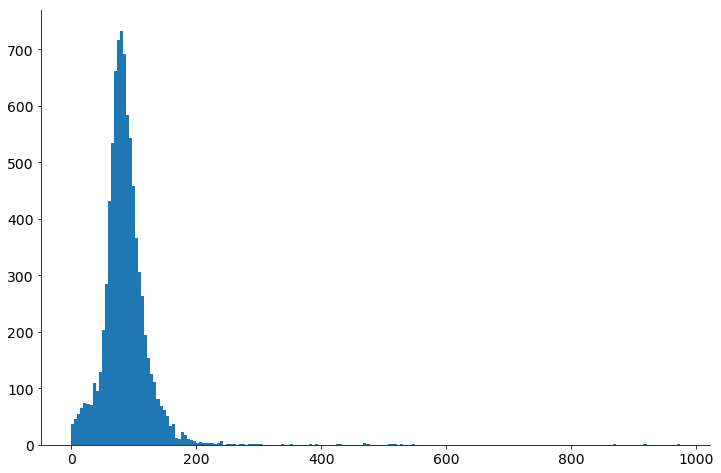

In [19]:
#plt.hist(df['Site EUI (kBtu/ft_2)'], bins=200)
plt.hist(df['Site EUI (kBtu/ft_2)'][df['Site EUI (kBtu/ft_2)']<1000], bins=200)
plt.show()

__Idea:__ Transform data to approximate the normal distribution --> Select cutoff thresholds based on standard deviations --> Return clean data

![title](../material/transformEUI.png)

### Question: Transform EUI and remove examples falling outside 2 std from the mean

In [20]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

df['eui'] = df['Site EUI (kBtu/ft_2)']
df['log_eui'] = np.log10(df.eui)
df = clean(df)
print 'Examples after cleaning EUI:', len(df)

Examples after cleaning EUI: 8369


In [22]:
df.eui.describe()

count    8369.000000
mean       87.188804
std        29.988660
min        21.000000
25%        69.200000
50%        83.400000
75%       101.300000
max       304.800000
Name: eui, dtype: float64

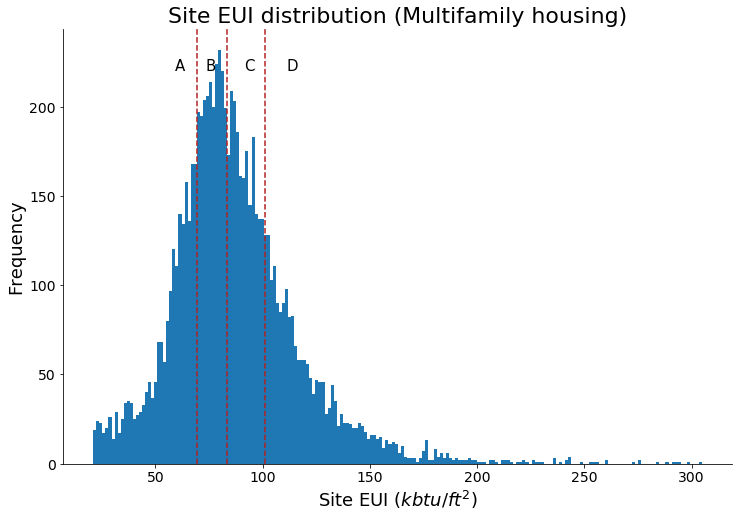

In [23]:
plt.hist(df['Site EUI (kBtu/ft_2)'], bins=200)
for label, pos in zip(['A', 'B', 'C'], df['Site EUI (kBtu/ft_2)'].describe()[4:7].values):
    plt.axvline(x=pos, color='firebrick', linestyle='--')
    plt.text(pos-10, 220, label, fontsize=15)
plt.text(pos+10, 220, 'D', fontsize=15)
plt.title('Site EUI distribution (Multifamily housing)')
plt.xlabel('Site EUI ($kbtu/ft^{2}$)')
plt.ylabel('Frequency')
plt.show()

# Understanding relationships

In [24]:
def makeCorrPlots(x, y):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    tmp = df[[x,y]]
    tmp = tmp.dropna()
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(tmp[x].astype(float), tmp[y])
    
    # plot2
    plt.scatter(tmp[x].astype(float), tmp[y], color=tableau20[0], alpha=0.5)
    plt.plot(tmp[x].astype(float),intercept + slope*tmp[x].astype('float'), color='firebrick')
    plt.title('%s v. %s (corr= %.2f)' %(y, x, np.corrcoef(tmp[x].astype('float'), tmp[y])[0][1]))

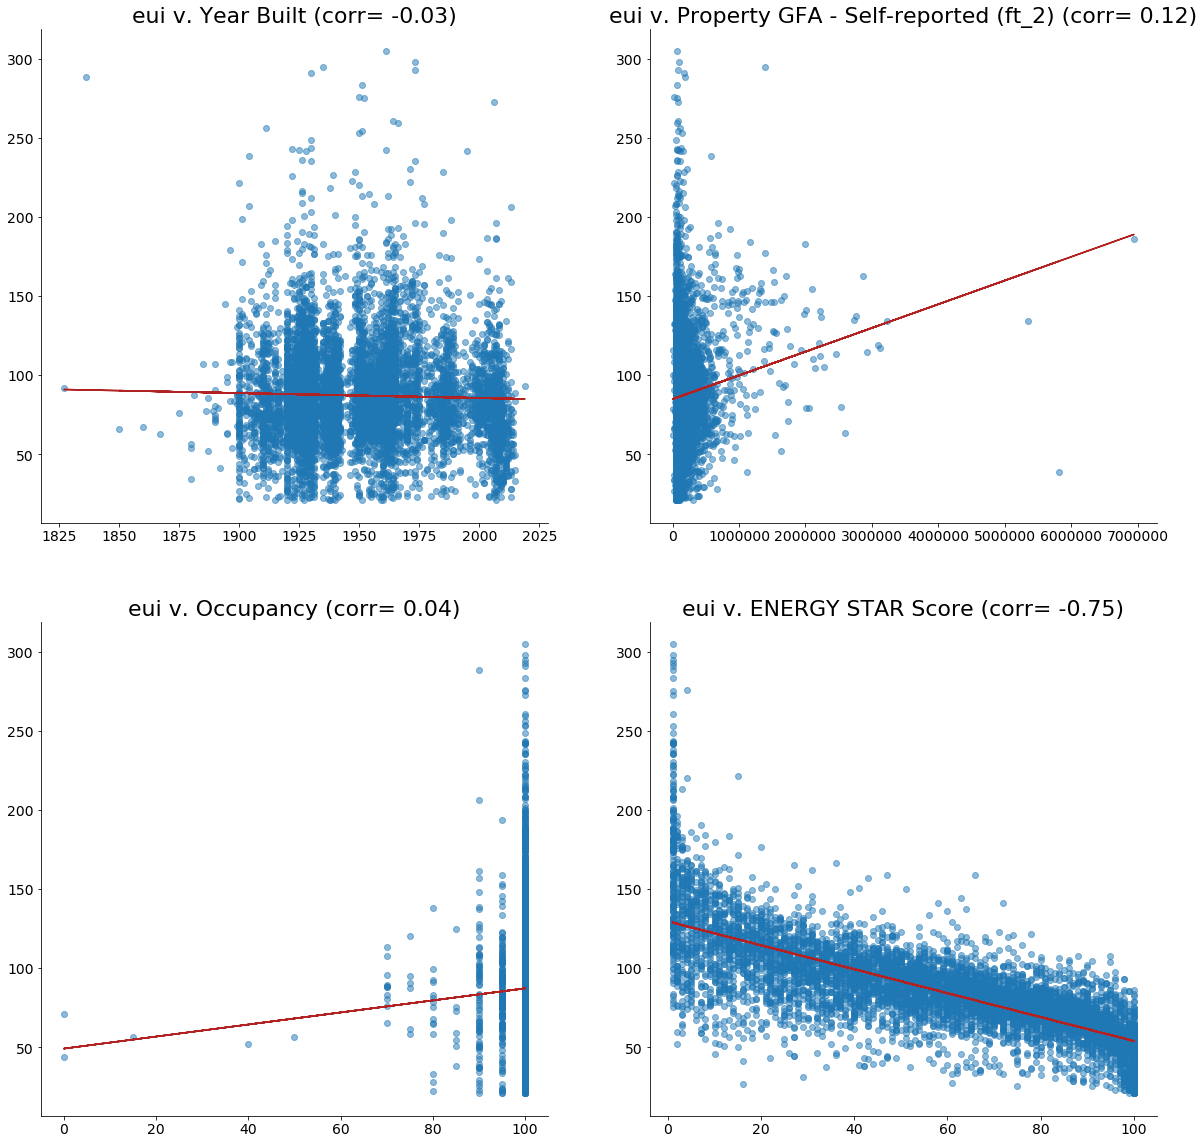

In [25]:
plt.figure(figsize=(20,20))
for i, var in enumerate(['Year Built', 'Property GFA - Self-reported (ft_2)', 'Occupancy', 'ENERGY STAR Score'],1):
    plt.subplot(2,2,i)
    makeCorrPlots(var, 'eui')

__Statistical Modeling__



* __Linear v. Non-linear__



* __Predicted efficiency v. Actual efficiency__